In [2]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm.auto import tqdm
from datacube.utils import geometry

sys.path.append('../../Scripts')
from dea_spatialtools import xr_rasterize
from dea_datahandling import wofs_fuser
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
#User inputs
Reservoir_gauge_data = '90_Library/Eildon_198801_sp-o10334.csv'
shapefile_of_reservoirs = '00_Library_reservois/00_Library_reservois.shp'
depth_interval_limit = 25
bad_rows = [0,1] #these are the bad rows you want to drop, like if the first depth slice image is bad, put 0. must be in square brackets

This reservoir will take every 2m instead of every 1m, because it is quite large.
Number of depth intervals =  24
Gauge ID =  sp-o10334


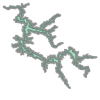

In [7]:
polygons_gdf = gpd.read_file(shapefile_of_reservoirs)
polygons_gdf = polygons_gdf.set_index(['gauge_ID'])

#Read gauge data
csv = Reservoir_gauge_data

#Get the ID of the gauge 
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID_str = gauge_number_df.at[0, 'gauge_ID']
#ID_str = ID_str.astype(str)  #If this box returns an error it might be because the ID for that gauge is already a string. 
                             #If you get an error about strings you can hash this line out.
                            #If you get a Key Error, unhash this line
        
#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

#Take every 2m of depth if the reservoir is large 
if len(integer_list) > depth_interval_limit:
    integer_list2 = integer_list[::2]
    print('This reservoir will take every 2m instead of every 1m, because it is quite large.')
else:
        integer_list2 = integer_list
        print('This reservoir will take every 1m of depth')
        
print('Number of depth intervals = ', len(integer_list2)) 

#Define the polygon
reservoir = polygons_gdf.loc[ID_str]
#ID = Eildon['gauge_ID']
polygon = reservoir.geometry
print('Gauge ID = ', ID_str)
polygon

In [5]:
#Make a query for the satellite data using the polygon
geom = geometry.Geometry(geom=polygon, crs=polygons_gdf.crs)
query = {'time': ('01-01-1988', '23-02-2021')}
query.update({'geopolygon': geom})

#Dask load wofs data
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', fuse_func = wofs_fuser, **query)

#Make a mask with the polygon
poly_mask = xr_rasterize(polygons_gdf, wofs_albers)
wofs_albers = wofs_albers.where(poly_mask, other=wofs_albers.water.nodata) #put other or all the data turns into 0

gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge

## The cloud mask doesn't appear to be working now that I'm using a polygon??

In [6]:
#Load satellite data for every depth interval
surface_area_list = []
number_of_images_list = []
images_post_masking = []
for i in tqdm(integer_list2, total=len(integer_list2)):
    #If there are more too many depth intervals, take every 2m depth
    if len(integer_list) > depth_interval_limit:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+2), drop=True)
    else:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    
    date_list = specified_level.time.values
    number_of_images = len(date_list)
    number_of_images_list.append(number_of_images)
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    images_post_masking.append(len(clear_specified_passes.time))
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
    
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
              
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list2, columns=['Depth'])
depth_to_area_df['Surface Area'] = surface_area_list
depth_to_area_df['Number of images before masking'] = number_of_images_list
depth_to_area_df['Number of images after masking'] = images_post_masking
depth_to_area_df['ID'] = ID_str
depth_to_area_df

  0%|          | 0/24 [00:00<?, ?it/s]

,Depth,Surface Area,Number of images before masking,Number of images after masking,ID
0,243,563750,3,3,sp-o10334
1,245,24866875,3,3,sp-o10334
2,247,27808750,11,11,sp-o10334
3,249,26980000,4,4,sp-o10334
4,251,34632500,18,18,sp-o10334
5,253,38750000,17,17,sp-o10334
6,255,42754375,21,21,sp-o10334
7,257,45886875,24,24,sp-o10334
8,259,50255000,62,62,sp-o10334
9,261,53458125,30,30,sp-o10334


In [10]:
#Interpolate
obs_list = []
for i, obs in depth_to_area_df.iterrows():
    if i == 0: #We always put the first point in, even if it's bad (will fix later)
        obs_list.append(obs)
        continue
    if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
        obs_list.append(obs)

obs_df = pd.DataFrame(obs_list)
obs_df2 = obs_df

#drop the first real images that are bad
obs_df2 = obs_df.drop(index=bad_rows) #Delete rows made from bad images

obs_df3 = obs_df2.set_index("Depth")
min_ = obs_df3.index.min()
max_ = obs_df3.index.max()
obs_df4 = obs_df3.reindex(range(min_, max_+1))
obs_df4['Surface Area'] = obs_df4['Surface Area'].interpolate()
obs_df4['Depth'] = obs_df4.index
obs_df4['ID'] = obs_df3.at[min_, 'ID']
obs_df4 = obs_df4[['ID', 'Depth', 'Surface Area', 'Number of images after masking']]
obs_df4 = obs_df4.set_index("ID")
obs_df4

,Depth,Surface Area,Number of images after masking
ID,,,
sp-o10334,247,27808750.0,11.0
sp-o10334,248,29514687.5,NaN
sp-o10334,249,31220625.0,NaN
sp-o10334,250,32926562.5,NaN
sp-o10334,251,34632500.0,18.0
sp-o10334,252,36691250.0,NaN
sp-o10334,253,38750000.0,17.0
sp-o10334,254,40752187.5,NaN
sp-o10334,255,42754375.0,21.0


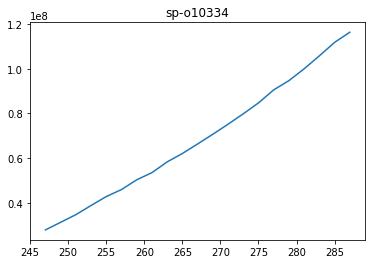

In [11]:
y_orig = list(obs_df4['Surface Area'])
x_orig = list(obs_df4['Depth'])
plt.title(ID_str)
plt.plot(x_orig, y_orig)
plt.show()